# Preparation steps

## Download the data:

### Option 1:
```bash
ssh myusername@weber...
```
or locally
```bash
mkdir leture04
cd lecture04
cp /tmp/mhd_fields.h5 .
```
Then, download this Jupyter notebook from here:
[https://www.app.physik.uni-potsdam.de/~jbenacek/ASPS/lecture04-handson.ipynb](https://www.app.physik.uni-potsdam.de/~jbenacek/ASPS/lecture04-handson.ipynb)

## Option 2:
Use link [https://www.app.physik.uni-potsdam.de/~jbenacek/ASPS/mhd_fields.h5](https://www.app.physik.uni-potsdam.de/~jbenacek/ASPS/mhd_fields.h5)

# 1. Basic particle motion + drifts 

In [1]:
%matplotlib inline
#%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Basic particle motion
- Observe particle trajectories and visualization of their motion.
- Investigate how various pushers impact the precision of the Larmor motion in the magnetic field.
- Investigate various particle drifts.
- How the size of time step dt influences the precision of particle position?
- Which of the particle pushers is the most precise?

## Define various particle pushers
- We want to solve the Lorentz force on a charged particle.
- Note: All pushers are non-relativistic

In [3]:
# Euler method
def Euler_push(particle, dt, E, B, q_m_ratio):
    velocity = particle[3:]
    E_local = E(particle[0], particle[1], particle[2])
    B_local = B(particle[0], particle[1], particle[2])
    #print("E,B", E_local, B_local)
    
    vx = velocity[0] + dt * q_m_ratio * (E_local[0] + velocity[1]*B_local[2] - velocity[2]*B_local[1])
    vy = velocity[1] + dt * q_m_ratio * (E_local[1] + velocity[2]*B_local[0] - velocity[0]*B_local[2])
    vz = velocity[2] + dt * q_m_ratio * (E_local[2] + velocity[0]*B_local[1] - velocity[1]*B_local[0])
    #print("New v", vx,vy,vz)
    
    x = particle[0] + dt * vx
    y = particle[1] + dt * vy
    z = particle[2] + dt * vz

    return np.array((x,y,z, vx,vy,vz))

In [4]:
# Kunge-Kutta fourth order method
def df(particle, dt, E, B, q_m_ratio):
    position = particle[:3]
    velocity = particle[3:]
    
    # Time dt is useless here because electromagnetic fields do not evolve in time
    E_local = E(position[0], position[1], position[2])
    B_local = B(position[0], position[1], position[2])
    #print("E,B", E_local, B_local)
   
    dvx = q_m_ratio * (E_local[0] + velocity[1]*B_local[2] - velocity[2]*B_local[1])
    dvy = q_m_ratio * (E_local[1] + velocity[2]*B_local[0] - velocity[0]*B_local[2])
    dvz = q_m_ratio * (E_local[2] + velocity[0]*B_local[1] - velocity[1]*B_local[0])

    return np.array((velocity[0], velocity[1], velocity[2], dvx,dvy,dvz))
    
def Runge_Kutta4_push(particle, dt, E, B, q_m_ratio):
    k1 = dt * df(particle, 0, E, B, q_m_ratio)
    k2 = dt * df(particle+k1/2, dt/2, E, B, q_m_ratio)
    k3 = dt * df(particle+k2/2, dt/2, E, B, q_m_ratio)
    k4 = dt * df(particle+k3, dt, E, B, q_m_ratio)
    particle += (k1+2.*k2+2.*k3+k4)/6.
    
    return particle

In [5]:
# Boris method
def Boris_push(particle, dt, E, B, q_m_ratio):
    E_local = E(particle[0], particle[1], particle[2])
    B_local = B(particle[0], particle[1], particle[2])
    velocity = particle[3:]
    
    uminus = velocity + q_m_ratio * E_local * dt/2.0
    h1 = q_m_ratio * B_local * dt / 2.0
    uprime = uminus + np.cross(uminus, h1)
    h2 = 2.0 * h1 / (1. + np.dot(h1, h1));
    uplus = uminus + np.cross(uprime, h2);
    u_new = uplus + q_m_ratio * E_local * dt / 2.0

    x = particle[0] + dt * u_new[0]
    y = particle[1] + dt * u_new[1]
    z = particle[2] + dt * u_new[2]

    return np.array((x,y,z, u_new[0],u_new[1],u_new[2]))

In [6]:
# Vay method
def Vay_push(particle, dt, E, B, q_m_ratio):
    E_local = E(particle[0], particle[1], particle[2])
    B_local = B(particle[0], particle[1], particle[2])
    velocity = particle[3:]
    
    vstart = velocity;
    un = vstart + q_m_ratio * dt / 2.0 * (E_local + np.cross(vstart, B_local))
    uprime = un + q_m_ratio * dt / 2.0 * E_local
    tau = q_m_ratio * dt / 2.0 * B_local
    sigma = 1 - np.dot(tau,tau);
    ustar = np.dot(uprime, tau);
    gammanew = np.sqrt(0.5 * (sigma + np.sqrt(sigma*sigma + 4.*(np.dot(tau, tau) + ustar*ustar))))
    t = tau / gammanew
    s = 1./(1. + np.dot(t, t))
    u_new = s * (uprime + np.dot(uprime, t)*t + np.cross(uprime, t));

    x = particle[0] + dt * u_new[0]
    y = particle[1] + dt * u_new[1]
    z = particle[2] + dt * u_new[2]

    return np.array((x,y,z, u_new[0],u_new[1],u_new[2]))

### Select your own pusher for the integrations below

In [7]:
my_push = Euler_push
# my_push = Runge_Kutta4_push
# my_push = Boris_push
# my_push = Vay_push

### Particle path integration

In [8]:
def integrate_particle(pusher, dt,
                       trajectory,
                       q_m_ratio, E, B):
    # Itegrates particle over a path of N time steps
    for i in range(1, trajectory.shape[0]):
        trajectory[i,:] = pusher(trajectory[i-1,:], dt, E, B, q_m_ratio)
    #return trajectory

In [9]:
N = 1000 # Number of time steps
dt = 0.01 # Time step size in relative units

In [10]:
# particle array
# index 0 - position x
# index 1 - position y
# index 2 - position z
# index 3 - position v_x
# index 4 - position v_y
# index 5 - position v_z
trajectory = np.zeros((N,6))

# Various particle motions

### Acceleration in electric field, no magnetic field

In [11]:
def E(x,y,z):
    return np.array((1,0,0))
def B(x,y,z):
    return np.array((0,0,0))

In [20]:
N = 100
trajectory = np.zeros((N,6))

In [21]:
integrate_particle(my_push, dt, trajectory,
                   q_m_ratio=1, E=E, B=B)

In [22]:
trajectory

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e-04, 0.000e+00, 0.000e+00, 1.000e-02, 0.000e+00, 0.000e+00],
       [3.000e-04, 0.000e+00, 0.000e+00, 2.000e-02, 0.000e+00, 0.000e+00],
       [6.000e-04, 0.000e+00, 0.000e+00, 3.000e-02, 0.000e+00, 0.000e+00],
       [1.000e-03, 0.000e+00, 0.000e+00, 4.000e-02, 0.000e+00, 0.000e+00],
       [1.500e-03, 0.000e+00, 0.000e+00, 5.000e-02, 0.000e+00, 0.000e+00],
       [2.100e-03, 0.000e+00, 0.000e+00, 6.000e-02, 0.000e+00, 0.000e+00],
       [2.800e-03, 0.000e+00, 0.000e+00, 7.000e-02, 0.000e+00, 0.000e+00],
       [3.600e-03, 0.000e+00, 0.000e+00, 8.000e-02, 0.000e+00, 0.000e+00],
       [4.500e-03, 0.000e+00, 0.000e+00, 9.000e-02, 0.000e+00, 0.000e+00],
       [5.500e-03, 0.000e+00, 0.000e+00, 1.000e-01, 0.000e+00, 0.000e+00],
       [6.600e-03, 0.000e+00, 0.000e+00, 1.100e-01, 0.000e+00, 0.000e+00],
       [7.800e-03, 0.000e+00, 0.000e+00, 1.200e-01, 0.000e+00, 0.000e+00],
       [9.100e-03, 0.000e

Text(0, 0.5, 'v$_x$')

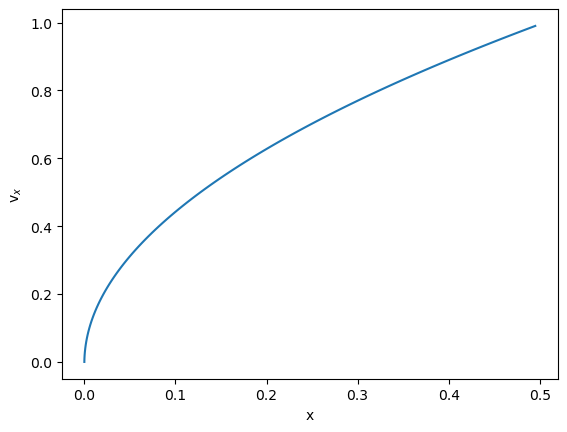

In [23]:
plt.figure()
plt.plot(trajectory[:,0], trajectory[:,3])
plt.xlabel("x")
plt.ylabel("v$_x$")

### Cyclotron motion

In [24]:
def E(x,y,z):
    return np.array((0,0,0))
def B(x,y,z):
    return np.array((0,0,1))

In [25]:
N = 10000
dt = 0.01
trajectory = np.zeros((N,6))
# Nonzero velocity in x
trajectory[0,3] = 1.0

In [26]:
integrate_particle(my_push, dt, trajectory,
                   q_m_ratio=1, E=E, B=B)

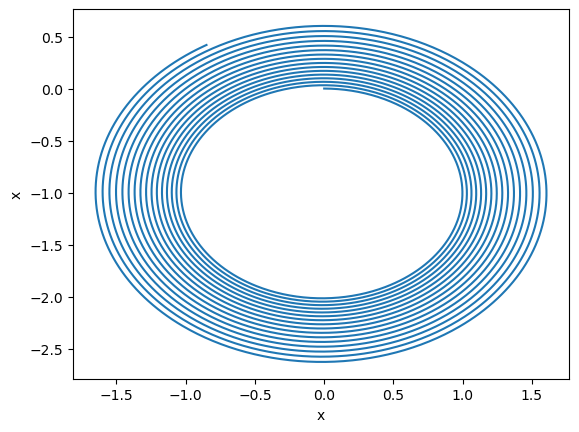

In [27]:
plt.figure()
plt.plot(trajectory[:,0], trajectory[:,1])
plt.xlabel("x")
plt.ylabel("x")
plt.show()

### Various solvers for cyclotron motion

In [32]:
def E(x,y,z):
    return np.array((0,0,0))
def B(x,y,z):
    return np.array((0,0,1))

In [33]:
N = 200
dt = 0.1

trajectory1 = np.zeros((N,6))
trajectory2 = np.zeros((N,6))
trajectory3 = np.zeros((N,6))
trajectory4 = np.zeros((N,6))

# Nonzero velocity in x
trajectory1[0,3] = 1.0
trajectory2[0,3] = 1.0
trajectory3[0,3] = 1.0
trajectory4[0,3] = 1.0

In [34]:
integrate_particle(Euler_push, dt, trajectory1,
                   q_m_ratio=1, E=E, B=B)
integrate_particle(Runge_Kutta4_push, dt, trajectory2,
                   q_m_ratio=1, E=E, B=B)
integrate_particle(Boris_push, dt, trajectory3,
                   q_m_ratio=1, E=E, B=B)
integrate_particle(Vay_push, dt, trajectory4,
                   q_m_ratio=1, E=E, B=B)

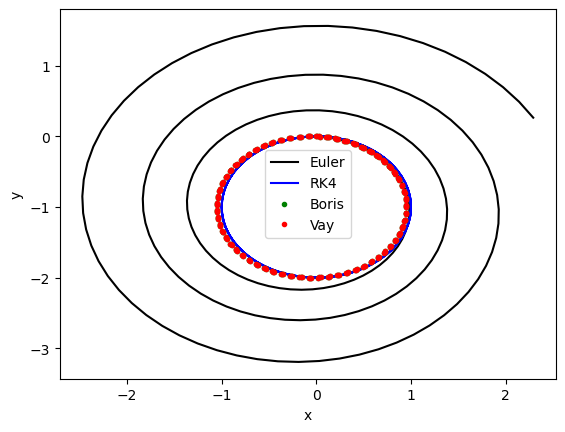

In [35]:
plt.figure()
plt.plot(trajectory1[:,0], trajectory1[:,1], "k", label="Euler")
plt.plot(trajectory2[:,0], trajectory2[:,1], "b", label="RK4")
plt.plot(trajectory3[:,0], trajectory3[:,1], "g.", label="Boris")
plt.plot(trajectory4[:,0], trajectory4[:,1], "r.", label="Vay")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Difference between Boris and Vay pushers
![Belyaev et al. (2015)](figs/Belyaev+2015-drift.jpg)


## Your turn here:
- Select a specific particle drift in arbitrary electromagnetic field and study particle motion
- Options:
  - E-B drift,
  - Grad B drift,
  - Curvature drift,
  - Magnetic mirror,
  - Oscillating electromagnetic waves
  - ...

# 2. Magnetic reconnection

### Import all necessary packages

In [36]:
from __future__ import print_function
import sys
import os
import h5py

import numpy as np
import math
import matplotlib as mpl
mpl.rc('figure', max_open_warning = 0)
import matplotlib.pyplot as plt
mpl.rcParams['contour.negative_linestyle'] = 'solid'
import scipy.interpolate as interpolate
import scipy.constants as constant
import psutil
import random
import time

### Selection of matplotlib inline vs. notebook

In [37]:
%matplotlib inline
#%matplotlib widget
from ipywidgets import *

## Plotting functions used throughout the notebook

In [38]:
#!mkdir figures

In [39]:
def contour_plot(field2d, fieldname, colorbar_label,
                 xgrid, ygrid, xppc=None, yppc=None , levels = None, field_levels = None, t_axis_ppc =  None,
                 plot_id = None):
    # limit memory usage when plotting repeatedly
    if plot_id is None:
        raise ValueError("Please pass a unique plot_id when calling this function!")
    fig1 = plt.figure(num=plot_id, clear=True)
    fig1.clf()
    
    field2d = field2d[:,:]
    fileplot = fieldname+'.png'
    #print('plotting :',fileplot )

    minfield = np.min(field2d)
    maxfield = np.max(field2d)
    #This makes the colortable symmetric around 0
    if np.abs(maxfield) >= np.abs(minfield):
        maxfield = - minfield
    else:
        minfield = - maxfield

    plt.imshow(np.transpose(field2d),aspect='auto',interpolation='spline36', cmap=mpl.cm.seismic,
               origin='lower', extent=[xgrid[0], xgrid[-1], ygrid[0], ygrid[-1]],
               vmin=minfield,vmax=maxfield)

    cbar=plt.colorbar()
    cbar.solids.set_rasterized(True)
    cbar.formatter.set_useOffset(False)
    plt.xlabel(r'x')
    plt.ylabel(r'y')
    plt.title(colorbar_label)
    plt.tight_layout()

    #plot particle trajectories
    if xppc is not None and yppc is not None:
        #plot_every_points=10**3
        #plt.scatter( [xppc.ravel()][::plot_every_points], (yppc.ravel())[::plot_every_points], color='green', s=0.1)
        plt.scatter( xppc.ravel(), yppc.ravel(), color='green', s=0.02)
        #
        number_points = len(xppc)
        #initial point
        xppc1 = (xppc.ravel())[0]
        yppc1 = (yppc.ravel())[0]
        #final point
        xppcl = (xppc.ravel())[-1]
        yppcl = (yppc.ravel())[-1]
        plt.plot(xppc1, yppc1, marker='o', markersize=7, color='green')
        plt.annotate(str(round(t_axis_ppc[0],3)), xy = (xppc1+0.05, yppc1+0.05),
                     xycoords='data',color="green", fontsize=8)
        plt.plot(xppcl, yppcl, marker='o', markersize=7, color='green')
        plt.annotate(str(round(t_axis_ppc[number_points-1],3)), xy = (xppcl+0.05, yppcl+0.05),
                     xycoords='data',color="green", fontsize=8)

    if levels is not None and field_levels is not None:
        cs = plt.contour(xgrid, ygrid, np.transpose(field_levels), levels = vector_levels, colors = 'black', linewidths=0.3)
        
    #plt.savefig("figures/"+fileplot)
    #plt.close(fig1)
    plt.show()

In [40]:
def line_plot(plotname ,yvec, xvec, ylabel, xlabel,
              linestyle1=None, yvec2=None, xvec2=None,
              ylabel2=None, linestyle2=None, yvec3=None, xvec3=None,
              ylabel3=None, linestyle3=None, yvec4=None, xvec4=None,
              ylabel4=None, linestyle4=None,
              ylabel_combined=None,
              plot_id = None):
    # limit memory usage when plotting repeatedly
    if plot_id == 'use_plotname':
        plot_id = plotname
    elif plot_id is None:
        raise ValueError("Please pass a unique plot_id when calling this function!")
    fig1 = plt.figure(num=plot_id, clear=True)
    fig1.clf()
    
    fileplot = plotname+'.'+'pdf'
    
    #print('plotting :',fileplot )

    plt.plot( xvec, yvec, label=ylabel, alpha=0.7, linewidth=1.0, color='black', linestyle=linestyle1)
    
    if yvec2 is not None:
        plt.plot( xvec2, yvec2, label=ylabel2, alpha=0.7, linewidth=1.0, color='red', linestyle=linestyle2)
        if yvec3 is not None:
            plt.plot( xvec3, yvec3, label=ylabel3, alpha=0.7, linewidth=1.0, color='blue', linestyle=linestyle3)
            if yvec4 is not None:
                plt.plot( xvec4, yvec4, label=ylabel4, alpha=0.7, linewidth=1.0, color='green', linestyle=linestyle4)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel_combined)
    leg=plt.legend()
    leg.get_frame().set_alpha(0.5)
    plt.tight_layout()

    #plt.savefig("figures/"+fileplot)
    #plt.close(fig1)
    plt.show()

### Reading the magnetic and velocity fields from the MHD snapshot

In [41]:
filename = 'mhd_fields.h5'
h5file = h5py.File(filename,"r")
bx_at_grid = np.array(h5file.get("/fields/magnetic/Bx"))[:,:]
by_at_grid = np.array(h5file.get("/fields/magnetic/By"))[:,:]
bz_at_grid = np.array(h5file.get("/fields/magnetic/Bz"))[:,:]
ux_at_grid = np.array(h5file.get("/fields/velocity/Ux"))[:,:]
uy_at_grid = np.array(h5file.get("/fields/velocity/Uy"))[:,:]
uz_at_grid = np.array(h5file.get("/fields/velocity/Uz"))[:,:]
h5file.close()
print('Fields read with shape: ', bx_at_grid.shape)
print('Total memory from psutil',  psutil.Process().memory_info().rss / (1024 * 1024*1024.), "GB")

Fields read with shape:  (12802, 400)
Total memory from psutil 0.2872352600097656 GB


## Part 1: MHD simulation parameters

In [42]:
#Grid creation
nx   = 12802 #total number of grid points along x (original simulation)
ny   = 3202  #total number of grid points along y (original simulation)
miny = 600   #minimum grid point along y (in h5 file)
maxy = 1000  #maximum grid point along y (in h5 file)
dx   = 0.025 #In units of l0
ny_effective = maxy - miny + 1
xgrid = np.arange(nx) * dx
ygrid = np.arange(ny_effective-1) * dx

In [43]:
# Degree of spline interpolation
interpolation_degree = 1

# Physical parameters
beta_p = 0.5 # Plasma beta
eta = 0.001  # Resistivity

# Physical constants
mu0 = constant.mu_0
epsilon_0 = constant.epsilon_0
c = constant.c
qe = constant.e
me = constant.m_e
mp = constant.m_p

# Normalizations constants
#print('### Unless otherwise stated, all physical parameters are in MKS units ###')
l0 = 2.5*10**4
t0 = 1.
B0 = 7.5*10**(-8)
charge = qe
mass = me

#Derived normalizations:
V0 = l0 / t0
V02c = V0 / c
n0 = B0**2 / (V0**2 * mu0 * mp) #Assuming V0 = VA (Alfven speed)
omega_pe = np.sqrt(n0 * charge**2 / (epsilon_0*me))
omega_pi = omega_pe / (mp/me)
proton_skin_depth = c / omega_pi
omega_ce = charge * B0 / mass
omega_cp = qe * B0 / mp
omega_pe2omega_ce = omega_pe / omega_ce
vthe2c = (beta_p/2.)**0.5/(omega_pe2omega_ce)
vthe = vthe2c*c
rhoe = vthe/omega_ce

#Assign frequency to be used by the particle pusher
omega_c = omega_ce

#print('n0 = ', n0)
#print('proton_skin_depth = ', proton_skin_depth)
print('l0/proton_skin_depth = ', l0/proton_skin_depth)
print('t0*omega_cp = ', t0*omega_cp)
#print('omega_pe = ', omega_pe)
#print('omega_ce = ', omega_ce)
print('Plasma frequency/cyclotron frequency = ', omega_pe2omega_ce)
print('V0/c = ', V02c)
print('vthe2c = ', vthe2c)
print('vthe/V0 = ', vthe2c/V02c)
print('l0/rhoe = ', l0/rhoe)
print('plasma beta = ', beta_p)
print('resistivity/(mu0*l0*B0) = ', eta)

j0 = B0 / (mu0*l0)
eta0 = mu0 * l0 * B0
#print('l0 = ', l0)
#print('t0 = ', t0)     
#print('V0 = ', V0)
#print('j0 = ', j0)
#print('j0 ', j0)
#print('eta0 ', eta0)

l0/proton_skin_depth =  0.16765614558844072
t0*omega_cp =  7.184124866957727
Plasma frequency/cyclotron frequency =  279.8506368726247
V0/c =  8.339102379953801e-05
vthe2c =  0.0017866673650901044
vthe/V0 =  21.425176040349832
l0/rhoe =  615.6845598817231
plasma beta =  0.5
resistivity/(mu0*l0*B0) =  0.001


## Part 2: Particle mover parameters

In [44]:
# Here setup iteration time
dt = 1e-5 #timestep for iterations
t = 0.    #initial value of t
tf = 3.0 #final time of iterations
nt = int(round(tf/dt)) #total number iterations

print('Particle mover: dt = ', dt)
print('Particle mover: dt*omega_ce = ', dt*omega_ce)
print('Particle mover: dt*omega_ce = ', dt*omega_cp)
#print('Particle mover: dt*omega_pe = ', dt*omega_pe)
print('Particle mover: total number iterations = ', nt)
print('Particle mover: final t = ', tf)
print('Particle mover: final t.omega_ce = ', tf*omega_ce)
print('Particle mover: final t.omega_cp = ', tf*omega_cp)

Particle mover: dt =  1e-05
Particle mover: dt*omega_ce =  0.13191150080791225
Particle mover: dt*omega_ce =  7.184124866957727e-05
Particle mover: total number iterations =  300000
Particle mover: final t =  3.0
Particle mover: final t.omega_ce =  39573.45024237367
Particle mover: final t.omega_cp =  21.55237460087318


In [45]:
#Initial conditions
#print('Generating array of initial conditions for particles ')

number_particles = 10                 # Total number particles
f = np.zeros((6, number_particles) )   # Particle position and velocity vector

f[0,:] = np.random.uniform(70, 100, size=number_particles) # x. It includes both an X and O point.
f[1,:] = np.repeat(5., number_particles)                   # y. 5. is at the current sheet midplane
f[2,:] = np.repeat(0, number_particles)                    # z
f[3,:] = np.random.uniform(-100., 100., size=number_particles) # v_x
f[4,:] = np.random.uniform(-60., 60., size=number_particles) # v_y
f[5,:] = np.random.uniform(-60., 60., size=number_particles) # v_z

#print('Total memory from psutil',  psutil.Process().memory_info().rss / (1024 * 1024*1024.), "GB")

### Calculating supplementary fields

In [46]:
#Ampere's law: curl B = j
curlbx_at_grid = np.gradient(bz_at_grid,dx,dx)[1] #- np.gradient(by,dx,dx,dx)[2]
curlby_at_grid = -np.gradient(bz_at_grid,dx,dx)[0] # + np.gradient(bx,dx,dx,dx)[2]
curlbz_at_grid = np.gradient(by_at_grid,dx,dx)[0] - np.gradient(bx_at_grid,dx,dx)[1]

#Resistive MHD Ohms law: E = -VxB + eta.j
ex_at_grid = by_at_grid*uz_at_grid - bz_at_grid*uy_at_grid + eta*curlbx_at_grid
ey_at_grid = bz_at_grid*ux_at_grid - bx_at_grid*uz_at_grid + eta*curlby_at_grid
ez_at_grid = bx_at_grid*uy_at_grid - by_at_grid*ux_at_grid + eta*curlbz_at_grid

#Vector potential for magnetic field lines
az = np.zeros((nx,ny_effective-1))
for j in range(1,ny_effective-1):
    az[0,j] = az[0,j-1] + 0.5*dx*(bx_at_grid[0,j-1] + bx_at_grid[0,j])
for i in range(1,nx):
    az[i,:] = az[i-1,:] - 0.5*dx*(by_at_grid[i-1,:] + by_at_grid[i,:])
vector_levels = np.array([0.00001,0.00005,0.0001,0.0005, 0.001,0.005,0.01,0.02,0.04,0.06, 0.08, 0.1, 0.2, 0.3,0.5,0.7,0.9])
vector_levels = az.min() + vector_levels* (az.max() - az.min())

### Debug for memory usage

In [47]:
print('Memory of all fields so far [Gb] = ', 13*bx_at_grid.nbytes/(1024.*1024.*1024.))
print('Total memory from psutil',  psutil.Process().memory_info().rss / (1024 * 1024*1024.), "GB")

Memory of all fields so far [Gb] =  0.247994065284729
Total memory from psutil 0.4404182434082031 GB


### Plotting input fields (default: current density and magnetic field lines)

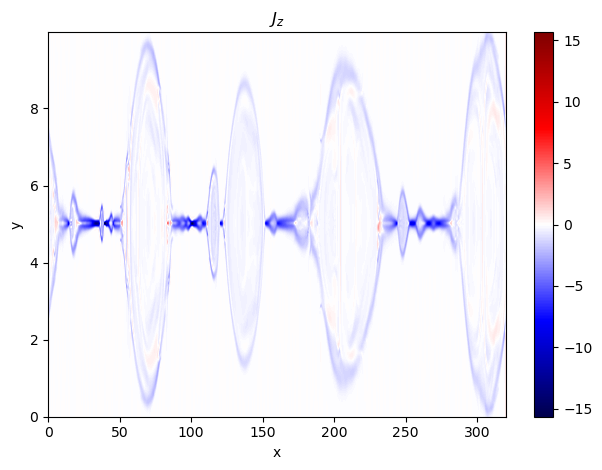

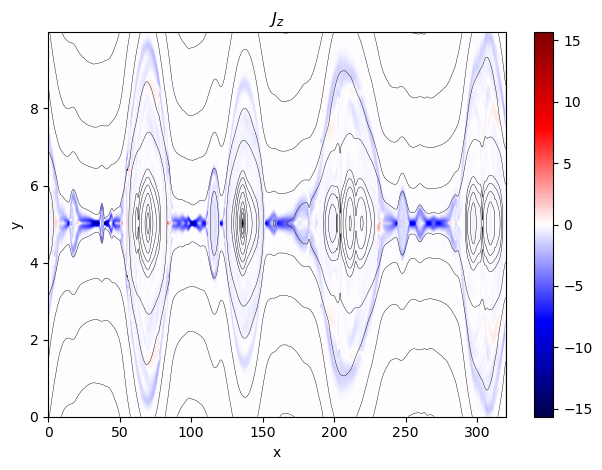

In [48]:
# Plot fields
#contour_plot(bx_at_grid, 'bx', r'$B_x$', xgrid, ygrid)
#contour_plot(by_at_grid, 'by', r'$B_y$', xgrid, ygrid)
#contour_plot(bz_at_grid, 'bz', r'$B_z$', xgrid, ygrid)

#contour_plot(curlbx_at_grid, 'jx', r'$J_x$', xgrid, ygrid)
#contour_plot(curlby_at_grid, 'jy', r'$J_y$', xgrid, ygrid)
contour_plot(curlbz_at_grid, 'jz', r'$J_z$', xgrid, ygrid, plot_id = 'curlbz_at_grid')
contour_plot(curlbz_at_grid, 'jz', r'$J_z$', xgrid, ygrid, levels = vector_levels, field_levels = az, plot_id = 'curlbz_at_grid with vector_levels')
#contour_plot(ez_at_grid, 'ez', r'$E_z$', xgrid, ygrid)

### Function to interpolate electric and magnetic fields to particle position

In [49]:
def fields_at_position(x,y):
    #Splines calculated elsewhere

    #Evaluate fields at particle's position using the splines coefficients
    bx_at_position = bx_spline.ev(x, y)
    by_at_position = by_spline.ev(x, y)
    bz_at_position = bz_spline.ev(x, y)

    #Get splines coefficients of EB fields
    ex_at_position = ex_spline.ev(x, y)
    ey_at_position = ey_spline.ev(x, y)
    ez_at_position = ez_spline.ev(x, y)

    return ex_at_position, ey_at_position, ez_at_position,\
           bx_at_position, by_at_position, bz_at_position

### Particle pusher/calculate force on the particles

In [50]:
def dfdt(f,t):
    df=np.zeros((6,number_particles))

    #many particles
    #particle's coordinates
    x = f[0,:]
    y = f[1,:]
    #z = f[2] #always zero for 2D
    #particle velocity components
    vx = f[3,:]
    vy = f[4,:]
    vz = f[5,:]

    #Get EB fields at particle's position
    ex, ey, ez, bx, by, bz = fields_at_position(x,y)

    #Lorentz force
    #For many particles
    df[0,:] = vx
    df[1,:] = vy
    df[2,:] = vz
    df[3,:] = omega_c*(ex + vy*bz - vz*by)
    df[4,:] = omega_c*(ey + vz*bx - vx*bz)
    df[5,:] = omega_c*(ez + vx*by - vy*bx)

    return df

### Calculating splines for interpolation

In [51]:
print('memory from psutil (before interpolation)',  psutil.Process().memory_info().rss / (1024 * 1024*1024.), "GB")
#Get splines coefficients of B fields
bx_spline = interpolate.RectBivariateSpline(xgrid, ygrid, bx_at_grid, kx=interpolation_degree, ky=interpolation_degree)
by_spline = interpolate.RectBivariateSpline(xgrid, ygrid, by_at_grid, kx=interpolation_degree, ky=interpolation_degree)
bz_spline = interpolate.RectBivariateSpline(xgrid, ygrid, bz_at_grid, kx=interpolation_degree, ky=interpolation_degree)

#Get splines coefficients of B fields
ex_spline = interpolate.RectBivariateSpline(xgrid, ygrid, ex_at_grid, kx=interpolation_degree, ky=interpolation_degree)
ey_spline = interpolate.RectBivariateSpline(xgrid, ygrid, ey_at_grid, kx=interpolation_degree, ky=interpolation_degree)
ez_spline = interpolate.RectBivariateSpline(xgrid, ygrid, ez_at_grid, kx=interpolation_degree, ky=interpolation_degree)

print('memory from psutil (after interpolation)',  psutil.Process().memory_info().rss / (1024 * 1024*1024.), "GB")

memory from psutil (before interpolation) 0.5752830505371094 GB
memory from psutil (after interpolation) 0.8042984008789062 GB


In [52]:
t_axis = np.array([])

x_vec  = np.zeros((nt+1,number_particles) )
y_vec  = np.zeros((nt+1,number_particles) )
z_vec  = np.zeros((nt+1,number_particles) )
vx_vec = np.zeros((nt+1,number_particles) )
vy_vec = np.zeros((nt+1,number_particles) )
vz_vec = np.zeros((nt+1,number_particles) )

### Moving particles by Runge-Kutta 4 (fourth-order)

In [53]:
counter_iter = 0
start_iter_time = time.time()
while (t <= tf ):
        if ((counter_iter % round(nt/20.))  ==  0):
            print('particle mover: iterating %',100.*counter_iter/float(nt))
            print('memory from psutil',  psutil.Process().memory_info().rss / (1024 * 1024*1024.), "GB")

        #print('counter_iter: ', counter_iter)
        t_axis = np.append(t_axis, t)

        x_vec[counter_iter,:] = f[0,:]
        y_vec[counter_iter,:] = f[1,:]
        z_vec[counter_iter,:] = f[2,:]
        vx_vec[counter_iter,:] = f[3,:]
        vy_vec[counter_iter,:] = f[4,:]
        vz_vec[counter_iter,:] = f[5,:]

        k1 = dt*dfdt(f,t)
        k2 = dt*dfdt(f+k1/2., t+dt/2.)
        k3 = dt*dfdt(f+k2/2., t+dt/2.)
        k4 = dt*dfdt(f+k3, t+dt)
        f += (k1+2.*k2+2.*k3+k4)/6.
        t += dt
        counter_iter += 1


print('total iterations ', counter_iter)
seconds_elapsed =  round(time.time()-start_iter_time,3)
print('total time elapsed in this script = ', seconds_elapsed,' [s] = ', seconds_elapsed/60.,' [m]')
del z_vec
print('Memory in particle data [Gb] = ', 5*x_vec.nbytes/(1024.*1024.*1024.))
#print('t_axis', t_axis)

particle mover: iterating % 0.0
memory from psutil 0.8042984008789062 GB
particle mover: iterating % 5.0
memory from psutil 0.8108901977539062 GB
particle mover: iterating % 10.0
memory from psutil 0.8176040649414062 GB
particle mover: iterating % 15.0
memory from psutil 0.8243179321289062 GB
particle mover: iterating % 20.0
memory from psutil 0.8310317993164062 GB
particle mover: iterating % 25.0
memory from psutil 0.8377456665039062 GB
particle mover: iterating % 30.0
memory from psutil 0.8444595336914062 GB
particle mover: iterating % 35.0
memory from psutil 0.8511734008789062 GB
particle mover: iterating % 40.0
memory from psutil 0.8578872680664062 GB
particle mover: iterating % 45.0
memory from psutil 0.8646011352539062 GB
particle mover: iterating % 50.0
memory from psutil 0.8713150024414062 GB
particle mover: iterating % 55.0
memory from psutil 0.8780288696289062 GB
particle mover: iterating % 60.0
memory from psutil 0.8847427368164062 GB
particle mover: iterating % 65.0
memory 

### Plot particle motion for given particle_id

In [54]:
initial_iteration = 0
final_iteration = nt #int(round(nt/3))
plot_every = int(4e2)
t_axis_reduced = t_axis[initial_iteration:final_iteration-1:plot_every]
print('Number of plotted timesteps = ', t_axis_reduced.shape, ' out of a total of = ', nt)

Number of plotted timesteps =  (750,)  out of a total of =  300000


In [55]:
#selecting particle with the most energy gain##
total_energy = (vx_vec[initial_iteration:final_iteration-1:plot_every]*vx_vec[initial_iteration:final_iteration-1:plot_every] + vy_vec[initial_iteration:final_iteration-1:plot_every]*vy_vec[initial_iteration:final_iteration-1:plot_every] + vz_vec[initial_iteration:final_iteration-1:plot_every]*vz_vec[initial_iteration:final_iteration-1:plot_every])
##
diff_final_initial_energy = total_energy[-1,:]-total_energy[0,:]
idx_sorted = np.argsort(diff_final_initial_energy)
#print('array index of n_fast_particles : ',idx_sorted)
#print('speed of n_fast_particles (with argsort) : ', diff_final_initial_energy[idx_sorted])
#print('index of particle with maximum energy gain : ', idx_sorted[-1], ', energy ', diff_final_initial_energy[idx_sorted[-1]])
#
particle_id = idx_sorted[-1]
print('plotting particle with ID ',particle_id) 

plotting particle with ID  4


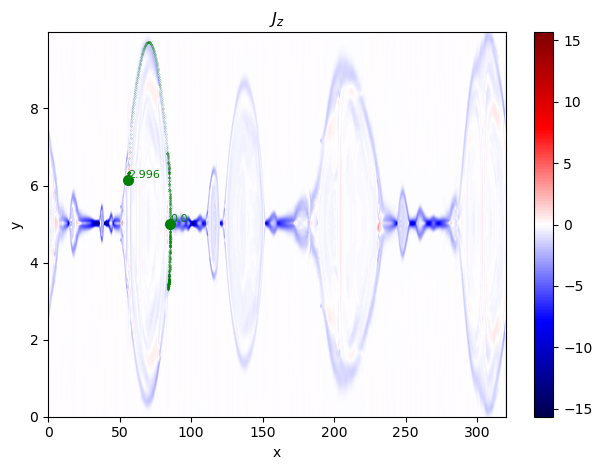

In [56]:
#particle_id = 1
#print('particle_id ', particle_id)
#print('x_vec[:,particle_id]', x_vec[:,particle_id])
#print('y_vec[:,particle_id]', y_vec[:,particle_id])
contour_plot(curlbz_at_grid, 'jz_1', r'$J_z$', xgrid, ygrid, xppc=x_vec[initial_iteration:final_iteration-1:plot_every,particle_id], yppc=y_vec[initial_iteration:final_iteration-1:plot_every,particle_id], t_axis_ppc=t_axis_reduced, plot_id="curlbz_at_grid_after run")

In [57]:
#particle_id = 0
#print('particle_id ', particle_id)
#print('x_vec[:,particle_id]', x_vec[:,particle_id])
#print('y_vec[:,particle_id]', y_vec[:,particle_id])
#contour_plot(curlbz_at_grid, 'jz_2', r'$J_z$', xgrid, ygrid, xppc=x_vec[initial_iteration:final_iteration:plot_every,particle_id], yppc=y_vec[initial_iteration:final_iteration:plot_every,particle_id], t_axis_ppc=t_axis_reduced)

### Calculating some derived particle quantities

In [58]:
#Calculating fields at position and derived quantities
ex, ey, ez, bx, by, bz = fields_at_position(x_vec[initial_iteration:final_iteration-1:plot_every],y_vec[initial_iteration:final_iteration-1:plot_every])
btotal = np.sqrt(bx*bx + by*by + bz*bz)
#print(ex.shape)
#print(x_vec.shape)
vpar_vec = vx_vec[initial_iteration:final_iteration-1:plot_every,:]*bx/btotal + vy_vec[initial_iteration:final_iteration-1:plot_every,:]*by/btotal + vz_vec[initial_iteration:final_iteration-1:plot_every,:]*bz/btotal
epar = ex*bx/btotal + ey*by/btotal + ez*bz/btotal
#print(vpar_vec.shape)
energy_par = vpar_vec*vpar_vec
energy_perp = total_energy - energy_par

#
magnetic_moment = energy_perp/btotal

##Drifts##
#ExB drift
ecrossb_x = (ey*bz - ez*by)/(btotal*btotal)
ecrossb_y = (ez*bx - ex*bz)/(btotal*btotal)
ecrossb_z = (ex*by - ey*bx)/(btotal*btotal)
##

###Calculating grad B drift
btotal_at_grid =  np.sqrt(bx_at_grid*bx_at_grid +  by_at_grid*by_at_grid + bz_at_grid*bz_at_grid)
gradb_x_at_grid = np.gradient(btotal_at_grid,dx,dx)[0] #- np.gradient(by,dx,dx,dx)[2]
gradb_y_at_grid = np.gradient(btotal_at_grid,dx,dx)[1] #- np.gradient(by,dx,dx,dx)[2]
gradb_x_spline = interpolate.RectBivariateSpline(xgrid, ygrid, gradb_x_at_grid, kx=interpolation_degree, ky=interpolation_degree)
gradb_y_spline = interpolate.RectBivariateSpline(xgrid, ygrid, gradb_y_at_grid, kx=interpolation_degree, ky=interpolation_degree)

gradb_x = gradb_x_spline.ev(x_vec[initial_iteration:final_iteration-1:plot_every],y_vec[initial_iteration:final_iteration-1:plot_every])
gradb_y = gradb_x_spline.ev(x_vec[initial_iteration:final_iteration-1:plot_every],y_vec[initial_iteration:final_iteration-1:plot_every])
del btotal_at_grid, gradb_x_at_grid, gradb_y_at_grid

gradbdrift_x = -energy_perp*bz*gradb_y/(btotal*btotal*btotal)
gradbdrift_y = energy_perp*bz*gradb_x/(btotal*btotal*btotal)
gradbdrift_z = energy_perp*(bx*gradb_y - by*gradb_x)/(btotal*btotal*btotal)

### Plot time evolution of single particle quantities

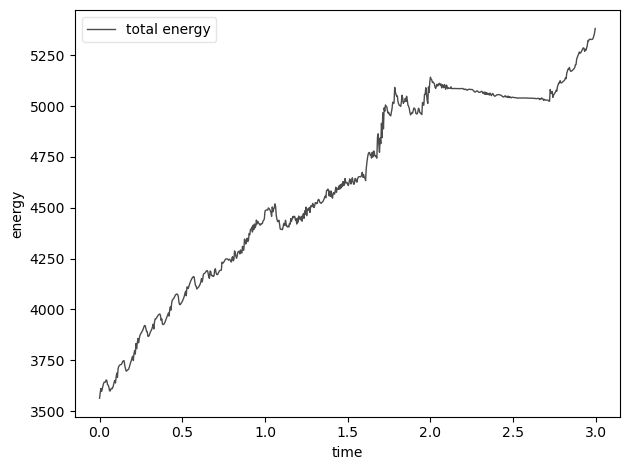

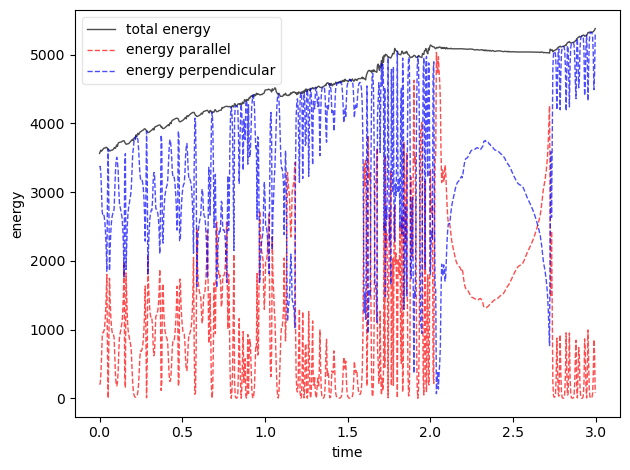

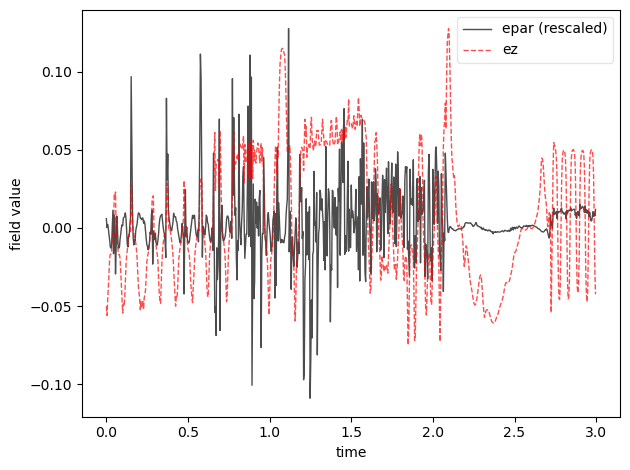

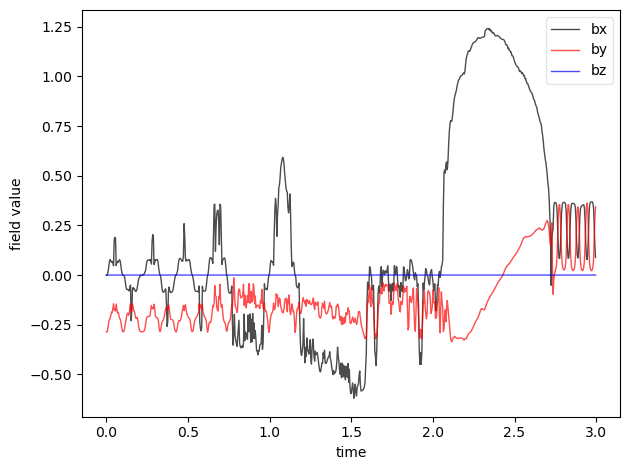

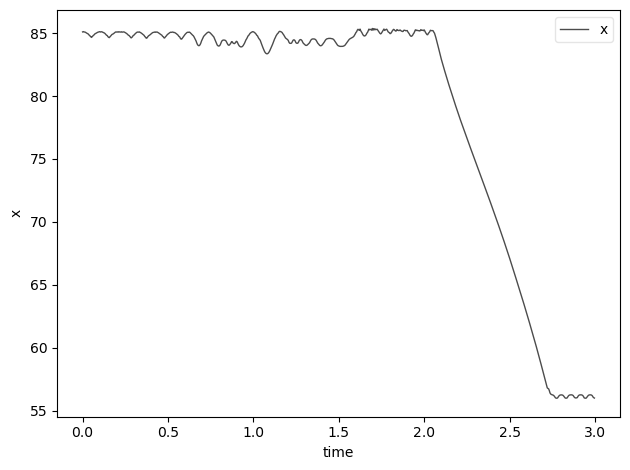

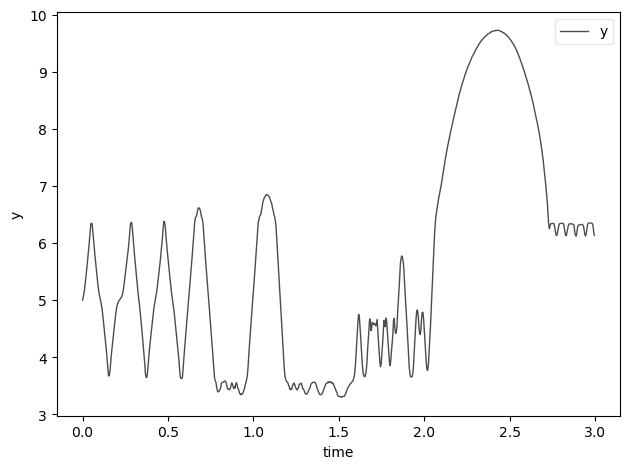

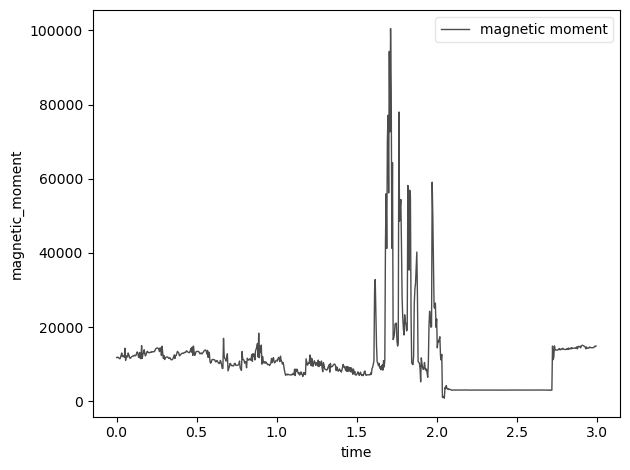

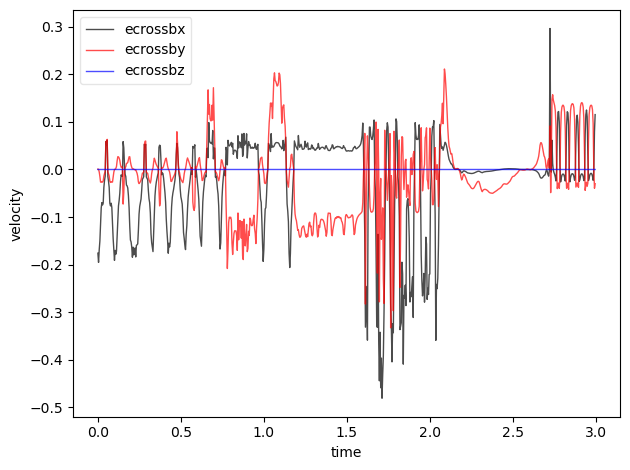

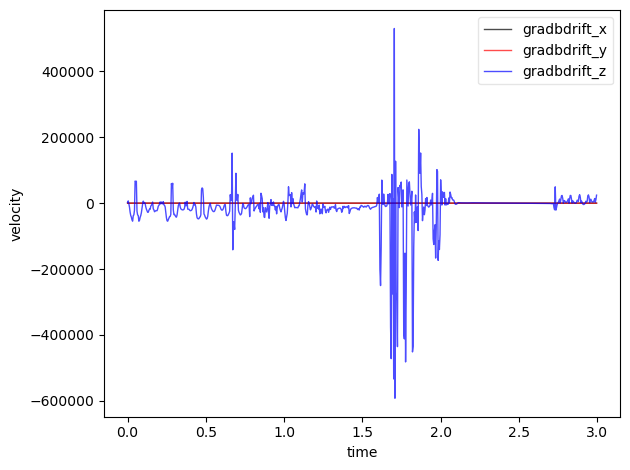

In [59]:
#Time evolution of different quantities for a single particle

line_plot('energy_evolution_total', total_energy[:,particle_id], t_axis_reduced, 'total energy',  'time',  linestyle1='-',
          ylabel_combined='energy', plot_id='use_plotname')
#line_plot('energy_evolution_components', total_energy[:,particle_id], t_axis_reduced, 'total energy',  'time',  linestyle1='-', \
#          yvec2=(vx_vec[initial_iteration:final_iteration-1:plot_every,particle_id])**2, xvec2=t_axis_reduced, ylabel2='energy X', linestyle2='--', \
#          yvec3=(vy_vec[initial_iteration:final_iteration-1:plot_every,particle_id])**2, xvec3=t_axis_reduced, ylabel3='energy Y', linestyle3='--', \
#          yvec4=(vz_vec[initial_iteration:final_iteration-1:plot_every,particle_id])**2, xvec4=t_axis_reduced, ylabel4='energy Z', linestyle4='--', \
#          ylabel_combined='energy', plot_id='use_plotname')
line_plot('energy_evolution_components2', total_energy[:,particle_id], t_axis_reduced, 'total energy',  'time',  linestyle1='-', \
          yvec2=energy_par[:,particle_id], xvec2=t_axis_reduced, ylabel2='energy parallel', linestyle2='--', \
          yvec3=energy_perp[:,particle_id], xvec3=t_axis_reduced, ylabel3='energy perpendicular', linestyle3='--', \
          ylabel_combined='energy', plot_id='use_plotname')
line_plot('efield_evolution_along_particle_trajectory', (epar[:,particle_id]/(np.max(epar[:,particle_id])))*np.max(ez[:,particle_id]), t_axis_reduced, 'epar (rescaled)',  'time',  linestyle1='-',
          yvec2=ez[:,particle_id], xvec2=t_axis_reduced, ylabel2='ez', linestyle2='--', \
          ylabel_combined='field value', plot_id='use_plotname')
line_plot('bfield_evolution_along_particle_trajectory', bx[:,particle_id], t_axis_reduced, 'bx',  'time',  linestyle1='-', \
          yvec2=by[:,particle_id], xvec2=t_axis_reduced, ylabel2='by', linestyle2='-', \
          yvec3=bz[:,particle_id], xvec3=t_axis_reduced, ylabel3='bz', linestyle3='-', \
          ylabel_combined='field value', plot_id='use_plotname')
line_plot('x position evolution along particle trajectory', x_vec[initial_iteration:final_iteration-1:plot_every,particle_id], t_axis_reduced, 'x',  'time',  linestyle1='-',ylabel_combined='x', plot_id='use_plotname')
line_plot('y position evolution along particle trajectory', y_vec[initial_iteration:final_iteration-1:plot_every,particle_id], t_axis_reduced, 'y',  'time',  linestyle1='-',ylabel_combined='y', plot_id='use_plotname')
line_plot('magnetic_moment_evolution', magnetic_moment[:,particle_id], t_axis_reduced, 'magnetic moment',  'time',  linestyle1='-', ylabel_combined='magnetic_moment', plot_id='use_plotname')
line_plot('exb_drifts', ecrossb_x[:,particle_id], t_axis_reduced, 'ecrossbx',  'time',  linestyle1='-', \
          yvec2=ecrossb_y[:,particle_id], xvec2=t_axis_reduced, ylabel2='ecrossby', linestyle2='-', \
          yvec3=ecrossb_z[:,particle_id], xvec3=t_axis_reduced, ylabel3='ecrossbz', linestyle3='-', \
          ylabel_combined='velocity', plot_id='use_plotname')
line_plot('gradbdrifts', gradbdrift_x[:,particle_id], t_axis_reduced, 'gradbdrift_x',  'time',  linestyle1='-', \
          yvec2=gradbdrift_y[:,particle_id], xvec2=t_axis_reduced, ylabel2='gradbdrift_y', linestyle2='-', \
          yvec3=gradbdrift_z[:,particle_id], xvec3=t_axis_reduced, ylabel3='gradbdrift_z', linestyle3='-', \
          ylabel_combined='velocity', plot_id='use_plotname')


In [60]:
#plt.close('all')
#Spectra (initial/final) of all particles
#(n_init, bins) = np.histogram(total_energy[0,:], bins=8)
#vec_xbins = .5*(bins[1:]+bins[:-1])
#dx_bin = bins[1] - bins[0]
#(n_final, bins) = np.histogram(total_energy[-1,:], bins=8)

#initial_spectra = n_init/(number_particles*dx_bin)
#final_spectra = n_final/(number_particles*dx_bin)

#line_plot('energy_spectra', initial_spectra, vec_xbins, 'initial',  'energy',  linestyle1='-',  yvec2=final_spectra, xvec2=vec_xbins, ylabel2='final', linestyle2='--', ylabel_combined='PDF')

In [61]:
print('End memory from psutil',  psutil.Process().memory_info().rss / (1024 * 1024*1024.), "GB")

End memory from psutil 0.8431396484375 GB
